In [1]:
import pandas as pd

# Bước 1: Đọc dữ liệu, giữ nguyên định dạng cột Date
df = pd.read_csv("META.csv", dtype={'Date': str})

# Bước 2: Thêm cột "Level" dựa trên sự thay đổi của Average Price so với dòng trước
df['Level'] = df['Close'].diff().apply(lambda x: 'Increase' if x > 0 else 'Decrease')
df.loc[0, 'Level'] = 'Decrease'  # Dòng đầu tiên mặc định là "Decrease"

# Bước 3: Xuất ra file mới
df.to_csv("META_stocks_with_Level.csv", index=False)

In [2]:
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_absolute_error, mean_squared_error, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Đọc dữ liệu
df = pd.read_csv("META_stocks_with_Level.csv")

# Chuyển cột 'Date' thành datetime
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%y')

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Level
0,2012-05-18,41.889986,44.828761,37.855398,38.084522,573576400,Decrease
1,2012-05-21,36.390988,36.520494,32.874422,33.900501,168192700,Decrease
2,2012-05-22,32.485908,33.462179,30.822263,30.882034,101786600,Decrease
3,2012-05-23,31.250625,32.376325,31.240663,31.878227,73600000,Increase
4,2012-05-24,32.824611,33.083620,31.649101,32.904305,50237200,Increase


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

# Thống kê số lượng 'Increase' và 'Decrease'
freq_increase = len(df[df['Level'] == 'Increase'])
freq_decrease = len(df[df['Level'] == 'Decrease'])
data = [freq_increase, freq_decrease]
labels = ['Increase', 'Decrease']

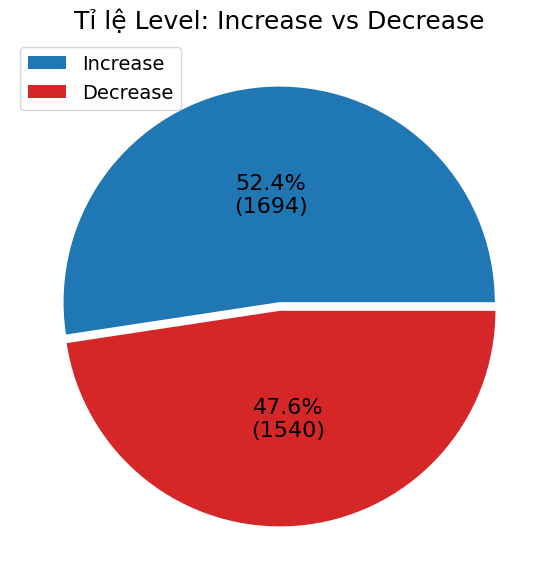

In [5]:
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Vẽ biểu đồ tỉ lệ 'Increase' vs 'Decrease'
fig, ax = plt.subplots(figsize=[11, 7])
plt.pie(
    x=data,
    autopct=lambda pct: func(pct, data),
    explode=[0.02]*2,
    pctdistance=0.5,
    colors=[sns.color_palette()[0], 'tab:red'],
    textprops={'fontsize': 16}
)
plt.legend(labels=labels, loc="best", prop={'size': 14})
plt.title('Tỉ lệ Level: Increase vs Decrease', fontsize=18)
plt.show()

In [6]:
# Xử lý dữ liệu
features = ['Open','High','Low','Close','Volume']
df_clean = df.dropna(subset=features + ['Level'])

X = df_clean[features]
y = df_clean['Level']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
# Chia train/test
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=100)

# Huấn luyện Random Forest
rf_model = RandomForestClassifier(random_state=100)
rf_model.fit(x_train, y_train)

# Dự đoán test
y_pred = rf_model.predict(x_test)

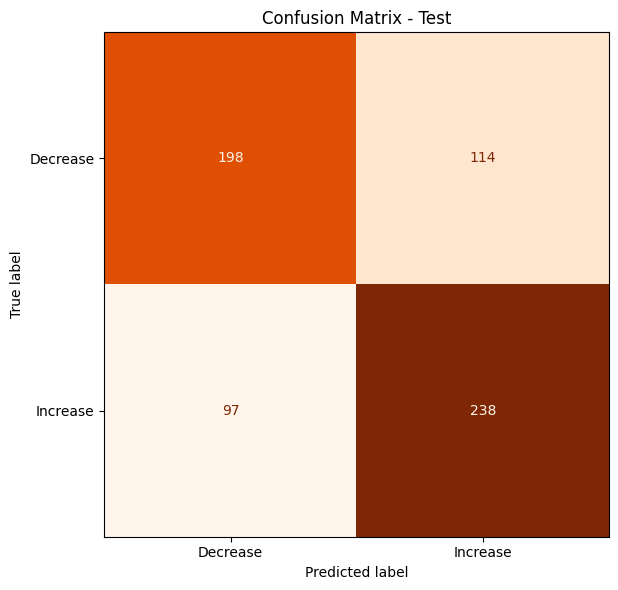

In [8]:
# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
disp_test.plot(ax=ax, cmap='Oranges', colorbar=False)
ax.set_title("Confusion Matrix - Test")
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report


def evaluate(y_true, y_pred, label='Set'):
    acc = accuracy_score(y_true, y_pred)
    print(classification_report(y_test, y_pred))
    print(f"{label} Metrics:")
    print(f"- Accuracy: {acc*100:.2f}%")
    print()

evaluate(y_test, y_pred, label="Test")



              precision    recall  f1-score   support

           0       0.67      0.63      0.65       312
           1       0.68      0.71      0.69       335

    accuracy                           0.67       647
   macro avg       0.67      0.67      0.67       647
weighted avg       0.67      0.67      0.67       647

Test Metrics:
- Accuracy: 67.39%



In [47]:
# ROC Curve
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_test_prob = rf_model.predict_proba(x_test)

if y_test_bin.shape[1] == 1:
    fpr_test, tpr_test, _ = roc_curve(y_test_bin, y_test_prob[:, 1])
else:
    fpr_test, tpr_test, _ = roc_curve(y_test_bin.ravel(), y_test_prob.ravel())

roc_auc_test = auc(fpr_test, tpr_test)

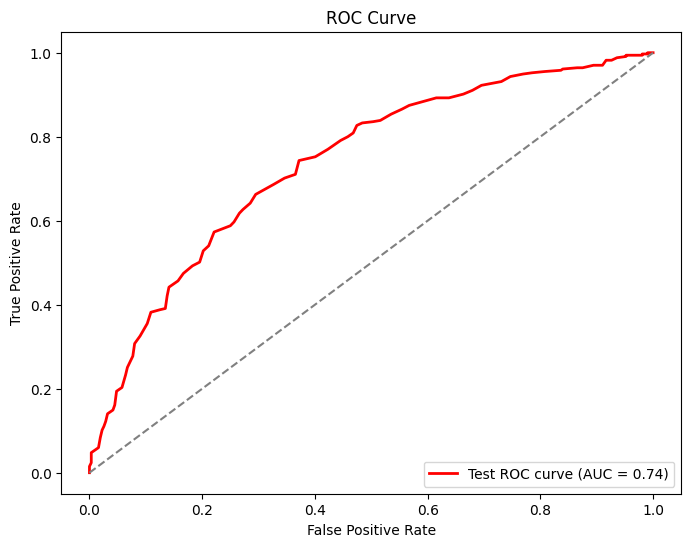

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [49]:
# Dự đoán 30 ngày tới
last_60_rows = df_clean[features].tail(60)
mean_values = last_60_rows.mean()
future_data = pd.DataFrame([mean_values]*30)
future_predictions = rf_model.predict(future_data)
future_labels = label_encoder.inverse_transform(future_predictions)

last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Level': future_labels
})

print(forecast_df)

         Date Predicted Level
0  2025-03-20        Increase
1  2025-03-21        Increase
2  2025-03-22        Increase
3  2025-03-23        Increase
4  2025-03-24        Increase
5  2025-03-25        Increase
6  2025-03-26        Increase
7  2025-03-27        Increase
8  2025-03-28        Increase
9  2025-03-29        Increase
10 2025-03-30        Increase
11 2025-03-31        Increase
12 2025-04-01        Increase
13 2025-04-02        Increase
14 2025-04-03        Increase
15 2025-04-04        Increase
16 2025-04-05        Increase
17 2025-04-06        Increase
18 2025-04-07        Increase
19 2025-04-08        Increase
20 2025-04-09        Increase
21 2025-04-10        Increase
22 2025-04-11        Increase
23 2025-04-12        Increase
24 2025-04-13        Increase
25 2025-04-14        Increase
26 2025-04-15        Increase
27 2025-04-16        Increase
28 2025-04-17        Increase
29 2025-04-18        Increase


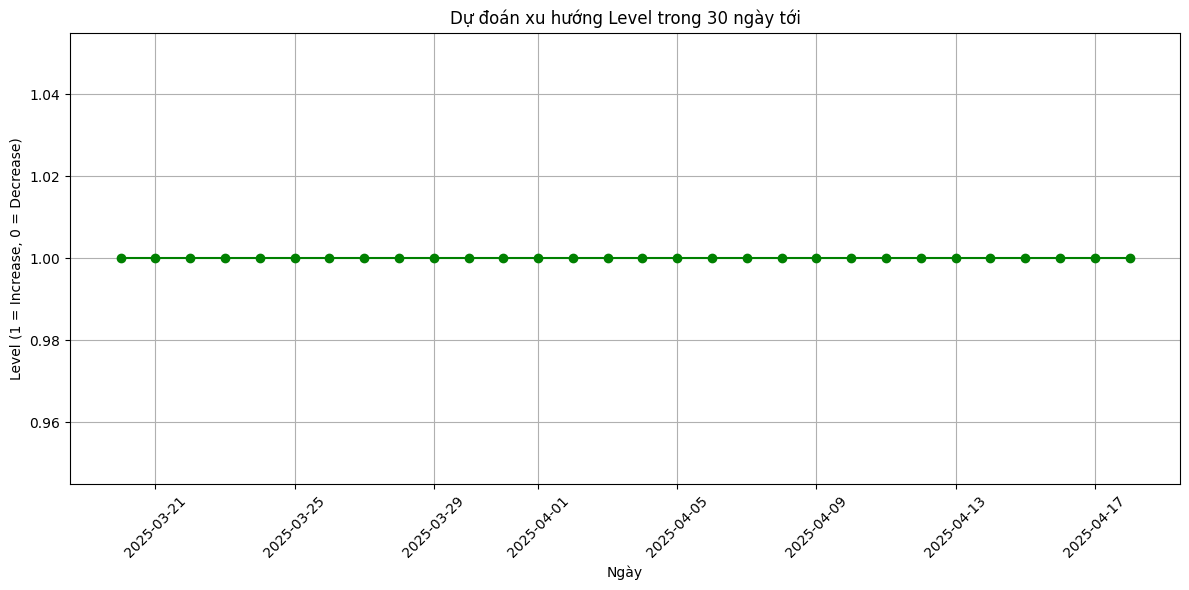

In [50]:
# Vẽ biểu đồ xu hướng 30 ngày
warnings.filterwarnings("ignore", message="Glyph 128200.*missing from font")
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Predicted Level'].apply(lambda x: 1 if x == 'Increase' else 0),
         marker='o', linestyle='-', color='green')
plt.title("Dự đoán xu hướng Level trong 30 ngày tới")
plt.xlabel("Ngày")
plt.ylabel("Level (1 = Increase, 0 = Decrease)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
